In [1]:
import os
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt
from copy import deepcopy
import json

from main import OncoTree, OncoNode
from util import save_result, ME_test, PR_test, Geweke, Gelman_Rubin, plot_df, calc_pair_mat
from scipy.special import logsumexp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
pd.options.display.float_format = '{:,.6f}'.format

In [3]:
cohort_name = 'tracerx' # or 'gdac_trees'
cancer_type = 'LUSC'

dataset_name = '%s/%s.json'%(cohort_name, cancer_type)
result_folder = '%s/%s'%(cohort_name, cancer_type)


data_file = 'data/%s'%dataset_name

details_file = 'result/%s/analysis_details.csv'%result_folder
best_sample_file = 'result/%s/progmo.pkl'%result_folder
raw_samples_file = 'result/%s/raw_samples.pkl'%result_folder
posteriors_file = 'result/%s/posteriors.csv'%result_folder
scans_file = 'result/%s/scans.npy'%result_folder
pdf_file = 'result/%s/postproc/best_sample.pdf'%result_folder
os.makedirs(os.path.dirname(pdf_file), exist_ok=True)

In [4]:
df_columns=['n_genes',
            'n_tumors',
            'star_log_pri',
            'star_log_llh',
            'star_log_post',
            'best_log_pri',
            'best_log_llh',
            'best_log_post',
            'pfp',
            'pfn',
            'post_improvement',
            'post_improvement (per-tumor)',
            'n_ones_in_data',
            'n_zeros_in_data',
            'n_FP',
            'n_FN',
            'n_errors',
            'time',
            'Geweke Z-score',
            'GR-score',
            'n_moves_mean',
            'n_moves_std']

In [5]:
df_details = pd.read_csv(details_file, delimiter=',', index_col=0, comment='#')

In [6]:
with open(details_file, 'r') as f:
    the_comments=''
    the_lines = []
    while True:
        line = f.readline()
        if not(line.startswith('#')):
            break
        else:
            the_comments += line[1:]
            the_lines.append(line[2:-2])
            if line[2:].startswith('Number of tumors: '):
                n_tumors = int(line[20:-1])
            elif line[2:].startswith('Number of genes: '):
                n_genes = int(line[19:-1])
            elif line[2:].startswith('Analysis time: '):
                spent_time = int(line[17:-9])
            elif line[2:].startswith('Star tree log likelihood: '):
                star_llh = float(line[28:-1])
            elif line[2:].startswith('Star tree log prior: '):
                star_pri = float(line[23:-1])
            elif line[2:].startswith('Star tree log posterior: '):
                star_post = float(line[27:-1])
            elif line[2:].startswith('Best sample log likelihood: '):
                best_llh = float(line[30:-1])
            elif line[2:].startswith('Best sample log prior: '):
                best_pri = float(line[25:-1])
            elif line[2:].startswith('Best sample log posterior: '):
                best_post = float(line[29:-1])
            elif line[2:].startswith('Best chain'):
                Geweke_Z_score = float(line[line.find('score:')+7:-2])
            elif line[2:].startswith('Gelman_Rubin'):
                GR_score = float(line[line.find('score:')+7:-2])

In [7]:
n_moves_mean = float('%.2f'%np.mean([df_details.loc['n_accepted(r0-c%i)'%i,:].sum() for i in range(10)]))
n_moves_std = float('%.2f'%np.std([df_details.loc['n_accepted(r0-c%i)'%i,:].sum() for i in range(10)]))
details = [n_genes, n_tumors, star_pri, star_llh, star_post, best_pri, best_llh, best_post]

In [8]:
if data_file.endswith('.csv'):
    df_input = pd.read_csv(data_file, delimiter=',', index_col=None, comment='#')
    if df_input.iloc[0, 0] not in [0, 1]:
        # The csv does have index column
        # RELOADING
        df_input = pd.read_csv(data_file, delimiter=',', index_col=0, comment='#')
    dataset_dic = {idx: np.array(df_input.loc[idx, :]).reshape(1, -1).astype(bool) for idx in df_input.index}
    weights_dic = {idx: np.array([[1.]]) for idx in df_input.index}
    gene_names = list(df_input.columns)
    print('CSV input successfully loaded\n')
else:
    with open(data_file, 'r') as f:
        json_dataset = json.load(f)
    dataset_dic = {
        key: np.array(json_dataset['clones'][key]).astype(bool)
        for key in json_dataset['clones'].keys()
    }
    weights_dic = {
        key: np.array(json_dataset['weights'][key]).reshape(-1, 1)
        for key in json_dataset['weights'].keys()
    }
    gene_names = list(json_dataset['gene_names'])
    print('JSON input successfully loaded\n')

JSON input successfully loaded



In [9]:
MI_scores, MI_log_pvalues, ME_log_pvalues = calc_pair_mat(np.concatenate([dataset_dic[key] for key in dataset_dic.keys()]))

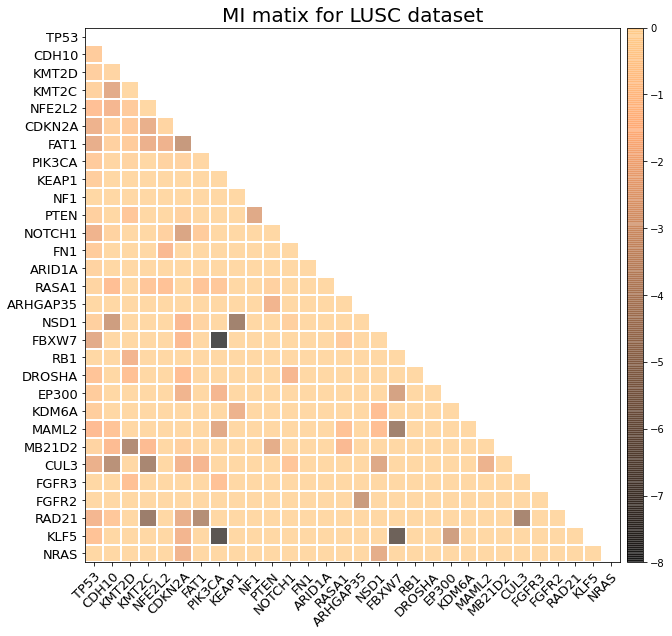

In [10]:
#fig, im = plot_df(pd.DataFrame(MI_log_pvalues), vmin=-8, vmax=0, cmap='Reds_r', fontsize=8, good_to_print=lambda x: False)
mask = np.triu(np.ones_like(MI_log_pvalues))
fig, im = plot_df(pd.DataFrame(np.ma.array(MI_log_pvalues, mask=mask)), vmin=-8, vmax=0, cmap='copper', fontsize=8, good_to_print=lambda x: False)
_ = fig.axes[0].set_xticklabels(gene_names)
_ = fig.axes[0].set_yticklabels(gene_names)
_ = fig.axes[0].set_title('MI matix for %s dataset'%cancer_type, fontsize=20)
divider = make_axes_locatable(fig.axes[0])
cax = divider.append_axes("right", size="3%", pad=0.1)
plt.colorbar(im, cax=cax)
#plt.savefig('result/%s/postproc/MI_matrix.pdf'%result_folder)

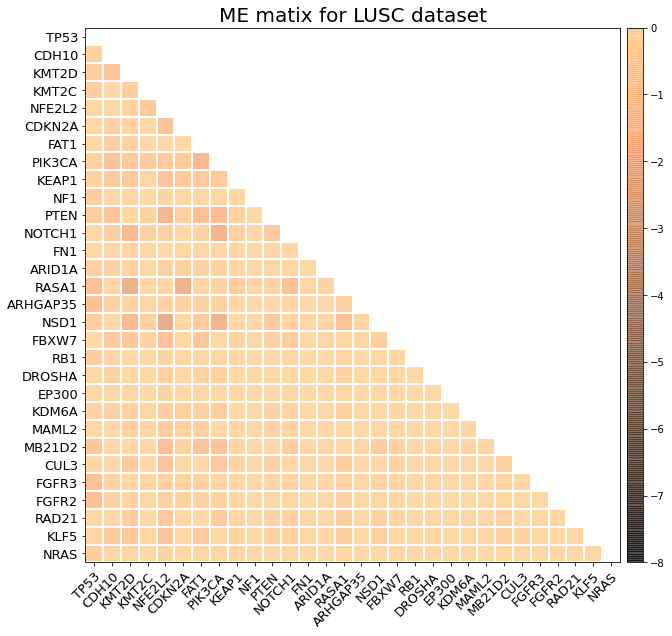

In [11]:
#fig, im = plot_df(pd.DataFrame(ME_log_pvalues), vmin=-8, vmax=0, cmap='Blues_r', fontsize=8, good_to_print=lambda x: False)
mask = np.triu(np.ones_like(ME_log_pvalues))
fig, im = plot_df(pd.DataFrame(np.ma.array(ME_log_pvalues, mask=mask)), vmin=-8, vmax=0, cmap='copper', fontsize=8, good_to_print=lambda x: False)
_ = fig.axes[0].set_xticklabels(gene_names)
_ = fig.axes[0].set_yticklabels(gene_names)
_ = fig.axes[0].set_title('ME matix for %s dataset'%cancer_type, fontsize=20)
divider = make_axes_locatable(fig.axes[0])
cax = divider.append_axes("right", size="3%", pad=0.1)
plt.colorbar(im, cax=cax)
#plt.savefig('result/%s/postproc/ME_matrix.pdf'%result_folder)

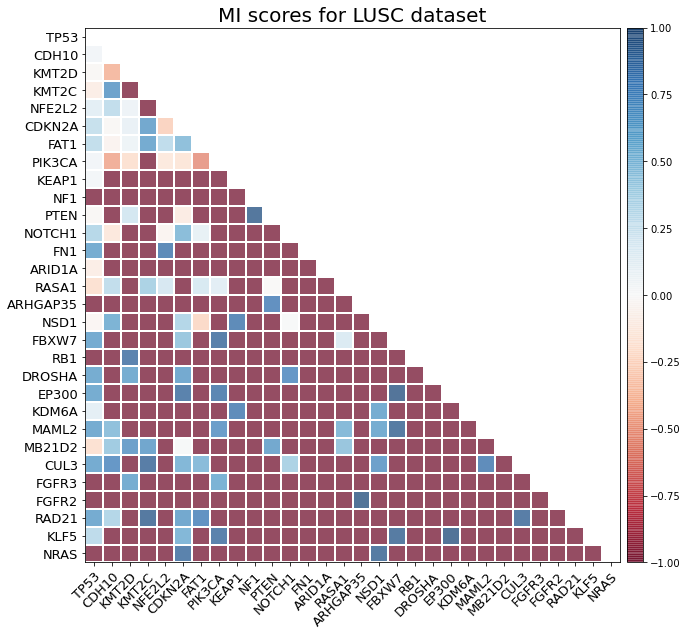

In [12]:
mask = np.triu(np.ones_like(MI_scores))
fig, im = plot_df(pd.DataFrame(np.ma.array(MI_scores, mask=mask)), vmin=-1, vmax=1, fontsize=8, cmap='RdBu', good_to_print=lambda x: False)
_ = fig.axes[0].set_xticklabels(gene_names)
_ = fig.axes[0].set_yticklabels(gene_names)
_ = fig.axes[0].set_title('MI scores for %s dataset'%cancer_type,fontsize=20)
divider = make_axes_locatable(fig.axes[0])
cax = divider.append_axes("right", size="3%", pad=0.1)
plt.colorbar(im, cax=cax)
#plt.savefig('result/%s/postproc/MI_scores.pdf'%result_folder)

In [13]:
with open(best_sample_file, 'rb') as f:
    sample = pickle.load(f)
details.append(sample.pfp)
details.append(sample.pfn)
details.append(np.exp((best_post-star_post)))
details.append(np.exp((best_post-star_post)/n_tumors))

In [14]:
# some calculations to recover the minimum number of false positives and false negatives
x,y,e = sample.min_errors(dataset_dic, weights_dic)
n_errors = e*n_tumors*n_genes

In [15]:
n_ones = np.sum([np.sum(weights_dic[key].reshape(-1)*dataset_dic[key].sum(axis=1)) for key in dataset_dic.keys()])
n_zeros = n_tumors*n_genes-n_ones
n_FP = (n_errors-(n_zeros + n_errors)*x)/(1-2*x)
n_FN = n_errors-n_FP
details.extend([n_ones, n_zeros, n_FP, n_FN, n_errors])
details.extend([spent_time, Geweke_Z_score, GR_score, n_moves_mean, n_moves_std])

In [16]:
_ = sample.to_dot(dataset_dic, weights_dic, gene_names=gene_names, fig_file=pdf_file)
details_dict = {df_columns[i]:details[i] for i in range(len(details))}

In [17]:
details_dict

{'n_genes': 30,
 'n_tumors': 32,
 'star_log_pri': 0.0,
 'star_log_llh': -160.1131,
 'star_log_post': -160.1131,
 'best_log_pri': 0.0,
 'best_log_llh': -137.0535,
 'best_log_post': -137.0535,
 'pfp': 0.0006353611598497508,
 'pfn': 0.0006353611598497508,
 'post_improvement': 10343250310.433603,
 'post_improvement (per-tumor)': 2.055691936430827,
 'n_ones_in_data': 72.50750304163289,
 'n_zeros_in_data': 887.4924969583672,
 'n_FP': 0.24053542709545003,
 'n_FN': 24.167231337608722,
 'n_errors': 24.40776676470417,
 'time': 19781,
 'Geweke Z-score': 0.088,
 'GR-score': 1.015,
 'n_moves_mean': 44318.9,
 'n_moves_std': 128.84}

In [18]:
n_clones = np.array([dataset_dic[key].shape[0] for key in dataset_dic.keys()])

In [19]:
print(n_clones.min(), n_clones.max(), n_clones.mean(), n_clones.std())

1 8 3.84375 1.9057376360611658


In [20]:
df_details.loc[['n_proposed(r0-c0)','n_novel(r0-c0)','n_accepted(r0-c0)'],:]

,hmerge,hsplit,vmerge,vsplit,swap,spr,gt
n_proposed(r0-c0),6716,6610,6654,6595,6729,33368,33328
n_novel(r0-c0),6228,6160,6654,6595,6728,31460,33324
n_accepted(r0-c0),3669,3620,2857,2891,3375,15475,12425


# Exploring raw_samples

In [21]:
with open(raw_samples_file, 'rb') as f:
    raw_samples = pickle.load(f)

In [22]:
pruned_samples = [item.prune(dataset_dic, weights_dic) for item in raw_samples[0]]

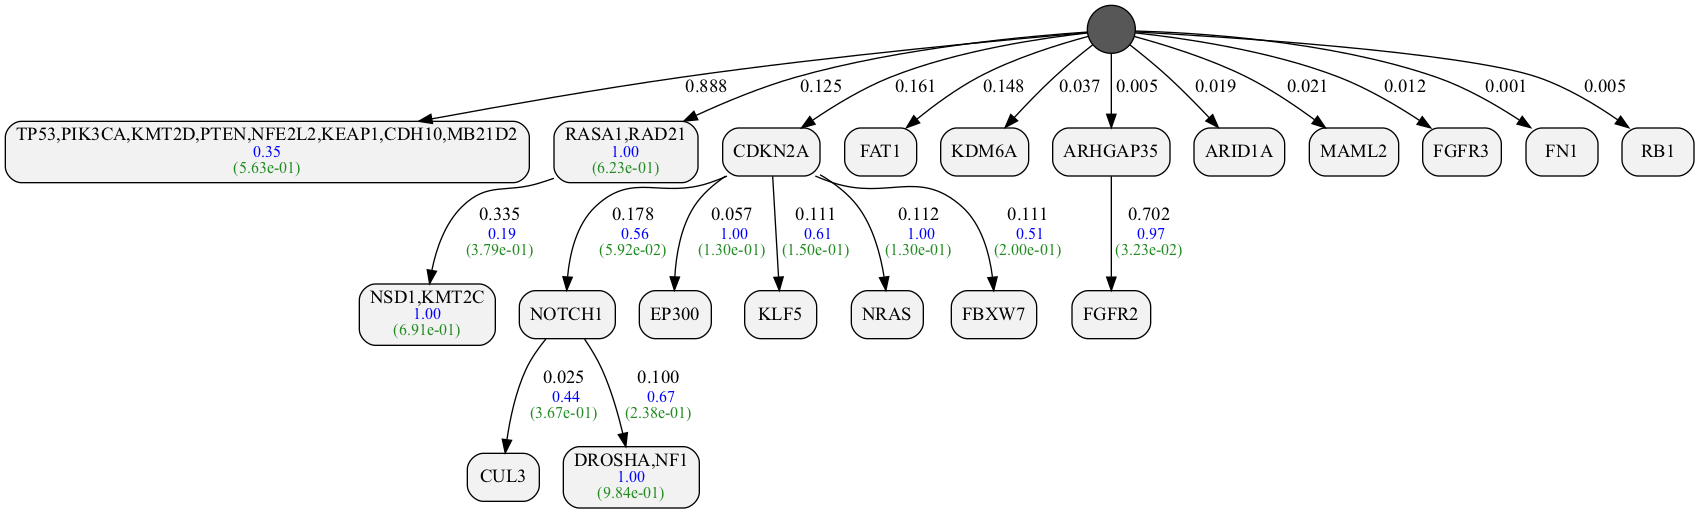

In [23]:
pruned_samples[0].to_dot(dataset_dic, weights_dic, gene_names)
Image('tmp.png')

In [24]:
[item.posterior(dataset_dic, weights_dic, pp=0) for item in pruned_samples]

[-140.83172207728623,
 -139.13179261433487,
 -149.34852461316655,
 -145.24316144497212,
 -144.04182096334387,
 -144.72292755869222,
 -141.13005511464266,
 -138.15480625279199,
 -143.82116749858903,
 -137.05346293504266]

In [25]:
posterior_table = pd.read_csv(posteriors_file, comment='#', index_col=0)

In [26]:
posterior_table

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,-160.113091,-160.113091,-160.113091,-160.113091,-159.297612,-159.019277,-159.019277,-159.019277,-159.019277,-159.019277,...,-152.506492,-152.506492,-152.486847,-152.486847,-152.486847,-152.487099,-152.487099,-152.487099,-152.487099,-154.431317
1,-159.843542,-159.843542,-159.843542,-159.843542,-159.843542,-159.843542,-159.843542,-159.452697,-159.325875,-159.202782,...,-145.741585,-145.741585,-145.945162,-147.461312,-145.963251,-145.963251,-145.963251,-145.963251,-145.963251,-152.244437
2,-160.113091,-159.532721,-159.532721,-159.532721,-159.246905,-158.850692,-159.111771,-158.800878,-158.250467,-158.250467,...,-147.303584,-147.303584,-147.268678,-147.268678,-147.268678,-146.984167,-146.984175,-146.984175,-146.984175,-150.482677
3,-160.113091,-160.113091,-160.113091,-159.835315,-159.827012,-159.796127,-159.683423,-159.683423,-159.360150,-159.360150,...,-152.706361,-152.706361,-152.706361,-152.675196,-152.675196,-153.119315,-153.119315,-153.119315,-153.119315,-161.313954
4,-160.113091,-160.113091,-160.113091,-160.113091,-160.113091,-160.113091,-160.113091,-160.113091,-160.113091,-160.113091,...,-143.576750,-143.576750,-143.813439,-144.050559,-144.050559,-144.050559,-144.050559,-144.081367,-144.130936,-146.940610
5,-160.113091,-160.003365,-160.003365,-160.003365,-160.156198,-160.115306,-160.115306,-160.150894,-160.145291,-159.834896,...,-150.520807,-150.520807,-150.520807,-150.520811,-150.517238,-150.517238,-150.517235,-150.517235,-150.517235,-153.511936
6,-160.113091,-160.113091,-160.113091,-159.637713,-158.972390,-158.972390,-158.972390,-158.972390,-158.556104,-157.750410,...,-143.039535,-143.039535,-143.039535,-143.039535,-143.039535,-143.039535,-143.039535,-143.039536,-143.039536,-154.154790
7,-160.113091,-160.113091,-160.113091,-160.113091,-160.113091,-160.131316,-160.131316,-159.334654,-159.327384,-159.327384,...,-143.609254,-143.609254,-143.609254,-143.948427,-143.948427,-143.948427,-143.948427,-144.015906,-143.494705,-148.760437
8,-160.113091,-160.115658,-161.207053,-160.928915,-160.903719,-160.903719,-160.026112,-159.932365,-159.930990,-159.610770,...,-148.492015,-148.492015,-148.492015,-148.492015,-149.793468,-149.793468,-149.793468,-149.793468,-149.793468,-152.763363
9,-159.815549,-159.792289,-159.792289,-159.792289,-159.792289,-159.792289,-159.792289,-159.792289,-159.646281,-159.646281,...,-145.753009,-146.268055,-146.268055,-146.268055,-146.268055,-146.268055,-146.268036,-146.290301,-146.359674,-149.655077


# Exploring posteriors

In [27]:
#pst = pd.read_csv('result/tracerx/%s/posteriors.csv'%cancer_type, index_col=0)
pst = pd.read_csv('result/%s/%s/posteriors.csv'%(cohort_name, cancer_type), index_col=0)

In [28]:
x = pst.iloc[0,:][::100]

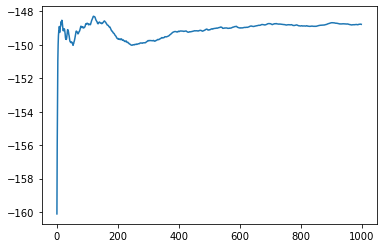

In [29]:
plt.plot(np.cumsum(np.array(x))/np.arange(1,len(x)+1))

In [30]:
with open(scans_file,'rb') as f:
    scans_tensor = np.load(f)

In [31]:
scans_tensor.shape

(31, 31, 10000, 10, 1)

In [32]:
post = scans_tensor[:,:,3000:,:,:].mean(axis=4).mean(axis=3).mean(axis=2)
cols = deepcopy(gene_names)
cols.append('root')

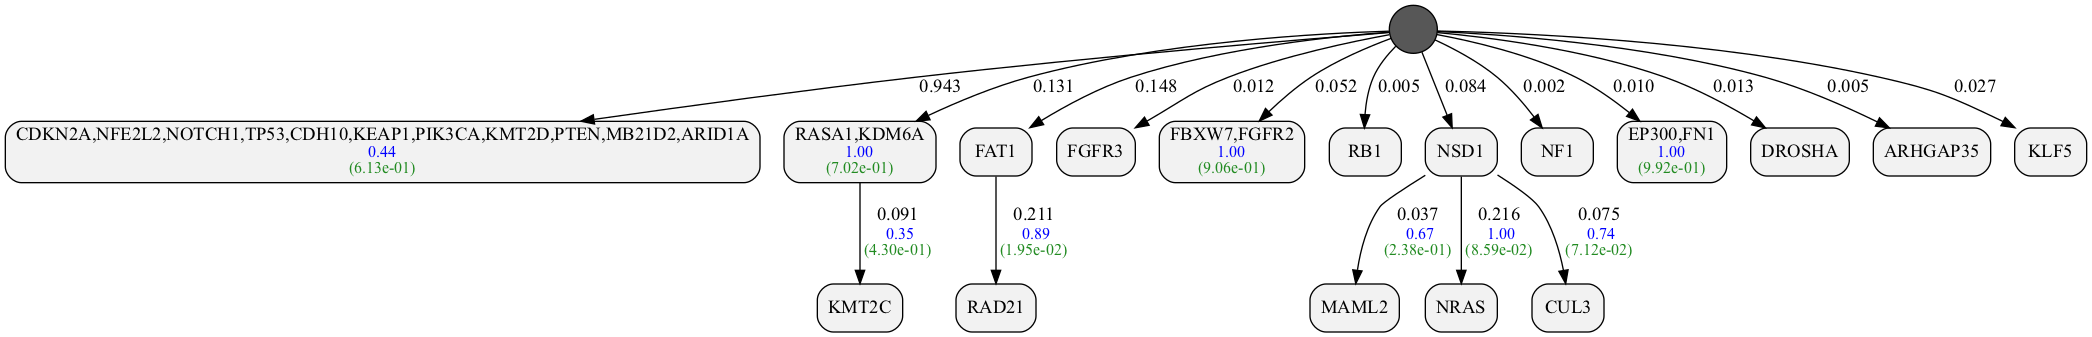

In [33]:
txt = sample.to_dot(dataset_dic, weights_dic, gene_names=gene_names)
Image('tmp.png')

In [34]:
best_sample_scan = sample.edge_scan()

Text(0.5, 0, 'To')

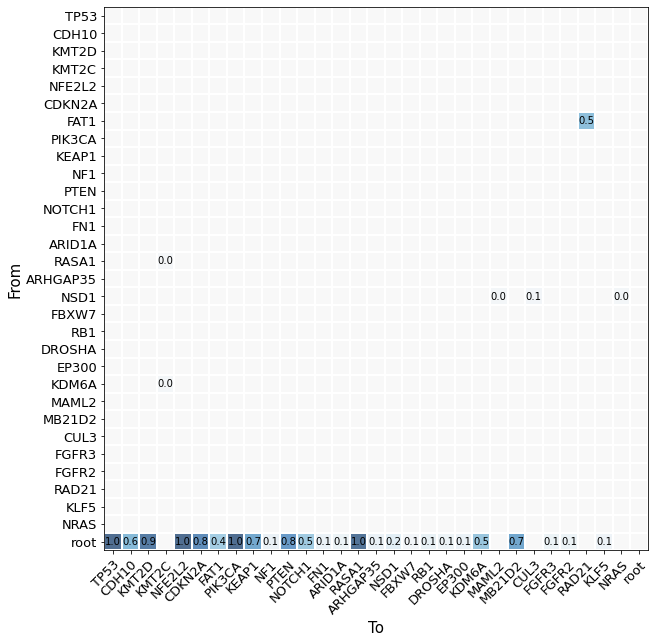

In [35]:
fig, im = plot_df(pd.DataFrame(best_sample_scan*post, columns=cols), vmin=-1, vmax=1, fontsize=10, good_to_print=lambda x: x>0)
fig.axes[0].set_ylabel('From', fontsize=15)
fig.axes[0].set_xlabel('To', fontsize=15)

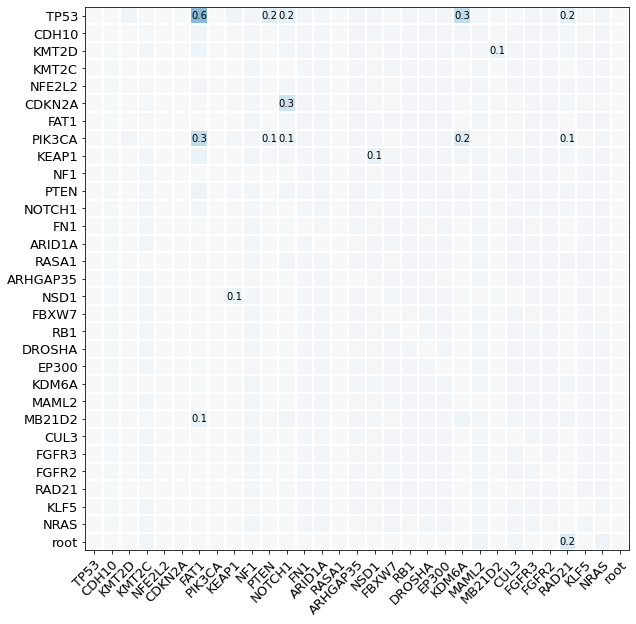

In [36]:
fig = plot_df(pd.DataFrame((1-best_sample_scan)*post, columns=cols), vmin=-1, vmax=1, fontsize=10, good_to_print=lambda x: x>0.1)

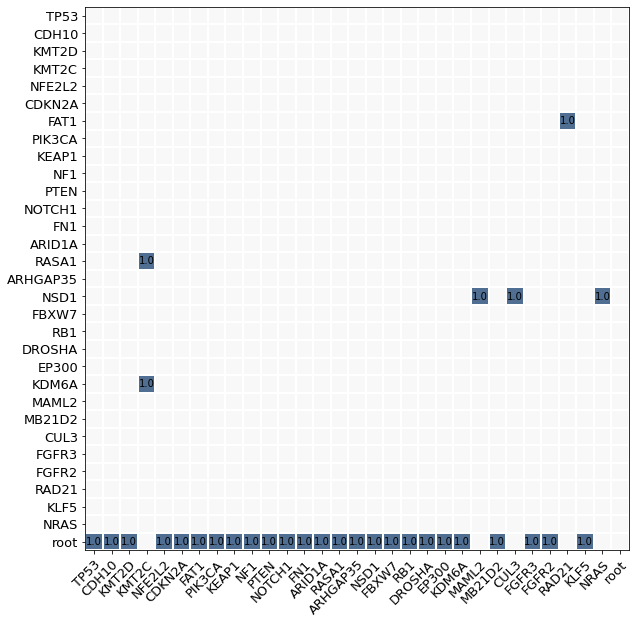

In [37]:
fig = plot_df(pd.DataFrame(best_sample_scan, columns=cols), vmin=-1, vmax=1, fontsize=10, good_to_print=lambda x: x>0.01)

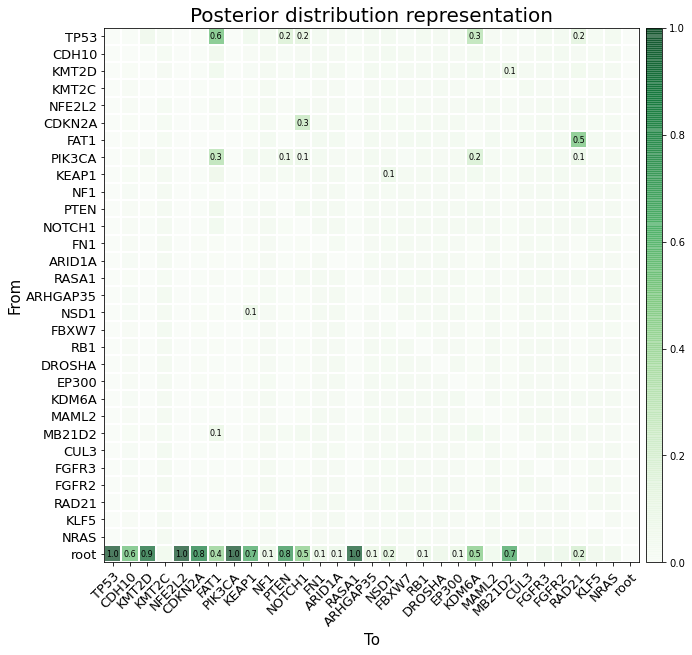

In [38]:
fig, im = plot_df(pd.DataFrame(post, columns=cols), vmin=0, vmax=1, cmap='Greens', fontsize=8, good_to_print=lambda x: x>=0.1)
fig.axes[0].set_ylabel('From', fontsize=15)
fig.axes[0].set_xlabel('To', fontsize=15)
fig.axes[0].set_title('Posterior distribution representation', fontsize=20)
divider = make_axes_locatable(fig.axes[0])
cax = divider.append_axes("right", size="3%", pad=0.1)
plt.colorbar(im, cax=cax)
#plt.savefig('result/%s/postproc/posterior.pdf'%result_folder, bbox_inches='tight', pad_inches=0.1)

In [39]:
the_post_df = pd.DataFrame(post, columns=cols, index=cols)
ME_df = pd.DataFrame(ME_log_pvalues, columns=gene_names, index=gene_names)
MI_df = pd.DataFrame(MI_log_pvalues, columns=gene_names, index=gene_names)
for node in sample.nodes:
    genes_in_node = [gene_names[i] for i in node.genes]
    print(genes_in_node)
    if node.is_root:
        pass
    else:
        if node.parent.is_root:
            genes_in_parent = ['root']
        else:  
            genes_in_parent = [gene_names[i] for i in node.parent.genes]
        print(genes_in_parent)
    if not(node.is_root):
        edge_posterior = 0
        counts = 0
        for v in genes_in_node:
            for u in genes_in_parent:
                edge_posterior += the_post_df.loc[u,v]
                counts += 1
        print(edge_posterior/counts)
    print(ME_df.loc[genes_in_node,:].loc[:,genes_in_node])
    if not(node.is_root):
        if not(node.parent.is_root):
            print(MI_df.loc[genes_in_parent,:].loc[:,genes_in_node])
    print('-----------------')
    

[]
Empty DataFrame
Columns: []
Index: []
-----------------
['CDKN2A', 'NFE2L2', 'NOTCH1', 'TP53', 'CDH10', 'KEAP1', 'PIK3CA', 'KMT2D', 'PTEN', 'MB21D2', 'ARID1A']
['root']
0.7259753246753248
          CDKN2A    NFE2L2    NOTCH1      TP53     CDH10     KEAP1    PIK3CA  \
CDKN2A  0.000000 -1.102782 -0.012793 -0.063645 -0.421784 -0.724428 -0.770104   
NFE2L2 -1.102782  0.000000 -0.454894 -0.170225 -0.061170 -1.039661 -0.832850   
NOTCH1 -0.012793 -0.454894  0.000000 -0.057565 -0.501502 -0.462444 -1.912093   
TP53   -0.063645 -0.170225 -0.057565  0.000000 -0.400039 -0.358928 -0.398456   
CDH10  -0.421784 -0.061170 -0.501502 -0.400039  0.000000 -0.636284 -1.284692   
KEAP1  -0.724428 -1.039661 -0.462444 -0.358928 -0.636284  0.000000 -0.858226   
PIK3CA -0.770104 -0.832850 -1.912093 -0.398456 -1.284692 -0.858226  0.000000   
KMT2D  -0.262158 -0.310786 -1.713035 -0.603140 -1.094275 -0.768814 -0.863118   
PTEN   -0.443012 -1.886513 -0.839500 -0.521440 -1.155016 -0.376708 -1.557660   
MB21D2 -0